# Downloading an OFA model from Hugging Face
__________________

This tutorial will walk you through getting an OFA (one for all) model up and running via huggingface on the HPCC. 


## Background

OFA is a pretrained unified multimodal sequence-to-sequence model. It is multimodal in the sense that in takes as input text and images at the same time. It it unified because it uses the same model on a variety of tasks (image captioning, visual quesiton answering, visual grounding, and more). It is pretrained, so by downloading a provided set of weights we can use the model on a variety of tasks. 


Before starting this tutorial, I suggest playing around with the online implimentations of OFA image captioning, visual question answering (https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption https://huggingface.co/spaces/OFA-Sys/OFA-vqa and https://huggingface.co/spaces/OFA-Sys/OFA-Visual_Grounding respectively). They each let you try out the three tasks we will impliment in python in a web interface. 

## Goals
---
By the end of this tutorial you should know how to:
- Create an Anaconda Enviroment for hugginface OFA
- Download the module and checkpoint for an OFA model
- Use the OFA model to do a variety of tasks

### Assumed Starting Point:
---
- You have installed Anaconda. (For help doing that, check here: https://docs.icer.msu.edu/Using_conda/)
- You have the ability to run this notebook on the HPCC. (For help doing that, check here: https://docs.icer.msu.edu/Python_on_HPC/ and here: https://docs.icer.msu.edu/Jupyter_Notebook_in_VS_Code/)


## Step 1: Setting up a Conda Enviroment
___
We will want to create a fresh enviroment for this tutorial, as we'll be using pip to install a specific OFA module. 

Run the following in the terminal:
```bash
conda create -n OFA_tutorial
conda activate OFA_tutorial
conda install -c anaconda ipykernel pillow matplotlib
conda install -c pytorch torchvision
```


We will also need git's large file storage, which we can activate by running:
```bash
module load git-lfs
```


## Step 2: Download the repositories for OFA and the OFA base checkpoint.
---
Run the following commands in the terminal:
```bash
git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA.git
pip install OFA/transformers/
git clone https://huggingface.co/OFA-Sys/OFA-base
```

The first clone is of the OFA repo, which contains functions for building the model.
The second clone is of the huggingface repo, which contains the specific weights for the model.

## Step 3) Import modules and set the stage to load in the model. 

In [77]:
from PIL import Image
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

Now that we have the packages and models ready, we can move on to defining some preprocessing steps. OFA expects three channel, normalized, square images as input. We'll set the mean and std deviation per channel, and the resolution as an int. 

In [4]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] 
resolution = 384

patch_resize_transform = transforms.Compose([
        lambda image: image.convert("RGB"),
        transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std)
    ])


## Step 4) Load in the pretrained tokenizer and model.

In [5]:
ckpt_dir = './OFA-base'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False)

./OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/mnt/home/fesslerl/anaconda3/envs/test_tutorial/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904639/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Step 5) Load in an example image
---
Feel free to use any image (higher quality is better). I'll be using an example image from the COCO (Common Objects in Context) Dataset (https://cocodataset.org/#home).

In [13]:
! wget http://images.cocodataset.org/val2017/000000397133.jpg -O test.jpeg

--2023-09-27 02:22:44--  http://images.cocodataset.org/val2017/000000397133.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.229.73, 16.182.103.97, 3.5.28.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.229.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200576 (196K) [image/jpeg]
Saving to: ‘test.jpeg’

100%[======================================>] 200,576      980KB/s   in 0.2s   

2023-09-27 02:22:45 (980 KB/s) - ‘test.jpeg’ saved [200576/200576]



In [14]:
path_to_image='test.jpeg'
img = Image.open(path_to_image)
patch_img = patch_resize_transform(img).unsqueeze(0)

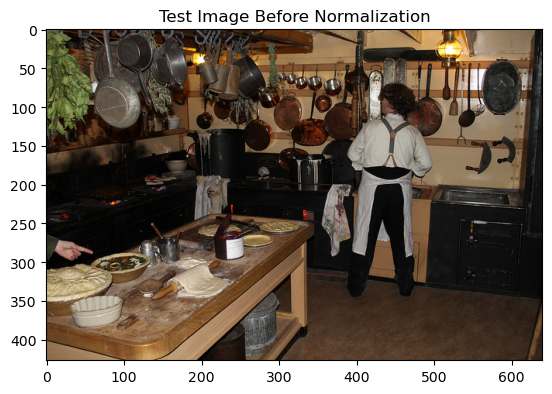

In [16]:
plot=plt.imshow(img)
plot=plt.title("Test Image Before Normalization")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


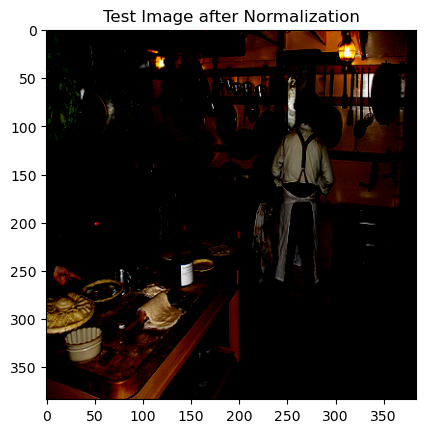

In [116]:
RGB=np.zeros((384,384,3))
RGB[:,:,0]=patch_img[0,0,:,:]
RGB[:,:,1]=patch_img[0,1,:,:]
RGB[:,:,2]=patch_img[0,2,:,:]
plot=plt.imshow(RGB)
plot=plt.title("Test Image after Normalization")

Two important things have changed about the image:
- The image is now square with 384 pixels per side.
- The image has been normalized in each channel. This has the visual effect of "darkening" the image, but do not worry about losing information. imshow "clips" images with negative pixel values to zero. The model does not have the same behavior, so can still "see" the image without it being darkened.

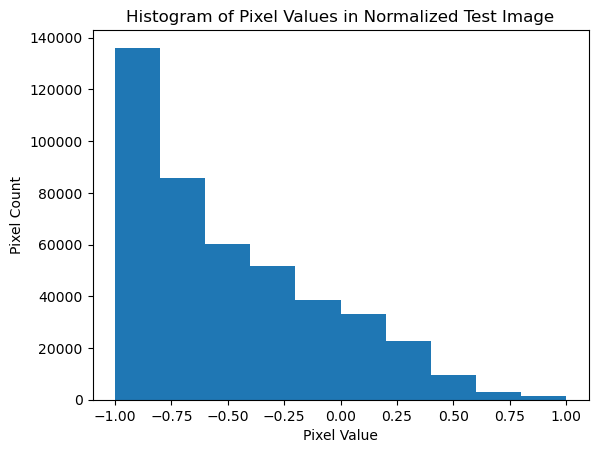

In [107]:
plot=plt.hist(np.ravel(RGB))
plot=plt.title('Histogram of Pixel Values in Normalized Test Image')
plot=plt.xlabel('Pixel Value')
plot=plt.ylabel('Pixel Count')

Our image, as you can see from this histogram, is particularly dark (many negative values after normalization). We can fix this for the visualization by moving the pixel values to the right one and dividing by two. 

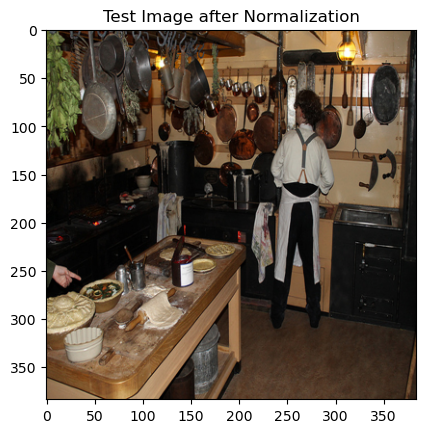

In [117]:
RGB= (RGB +1)/2
plot=plt.imshow(RGB)
plot=plt.title("Test Image after Normalization")

## Task 1) Image Captioning
---
Input: Image and prompt "what does the image describe?"


Output: Narrative associated with the image.

In [45]:
txt = "what does the image describe?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: what does the image describe?
Answer:  person and i cooking in the kitchen.


## Task 2) Visual Question Answering
---
Input: Image and question about image.


Output: Short answer to question.

In [47]:
txt = "what is in the top left?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: what is in the top left?
Answer:  pots and pans


In [136]:
txt = "where is this image taken?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: where is this image taken?
Answer:  in a kitchen


In [49]:
txt = "what is the person doing in this image?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: what is the person doing in this image?
Answer:  cooking


In [53]:
txt = "what food is in the image?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: what food is in the image?
Answer:  pie


In [50]:
txt = "what is the person wearing?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: what is the person wearing?
Answer:  apron


In [51]:
txt = "what color is the apron?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
print(f"Instruction: {txt}")
print(f"Answer: {tokenizer.batch_decode(gen, skip_special_tokens=True)[0]}")

Instruction: what color is the apron?
Answer:  black and white


## Task 3) Visual Grounding
---
Input: Image and question "Which region does the text " [description] " describe?

Output: Location in image.

In [128]:
def bin2coord(bins):
    # The model will output "bin locations" (a rolling index of pixels), not pixel locations. For plotting we would like to use pixel locations. This function converts between the two. 
    bin_list = [int(bin[5:-1]) for bin in bins.strip().split()]
    coord_list = []
    coord_list += [bin_list[0] / (768 - 1) * 384]
    coord_list += [bin_list[1] / (768 - 1) * 384]
    coord_list += [bin_list[2] / (768 - 1) * 384]
    coord_list += [bin_list[3] / (768 - 1) * 384]
    return coord_list

def plot_image_and_rect(bins, txt):
    # Given the bin locations, plot the image with the model's output in a blue rectangle
    fig, ax = plt.subplots()
    ax.imshow(RGB)
    coords=bin2coord(bins)
    rect = patches.Rectangle((coords[0], coords[1]), coords[2]-coords[0], coords[3]-coords[1], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    plt.title(txt)
    plt.axis('off')
    plt.show()

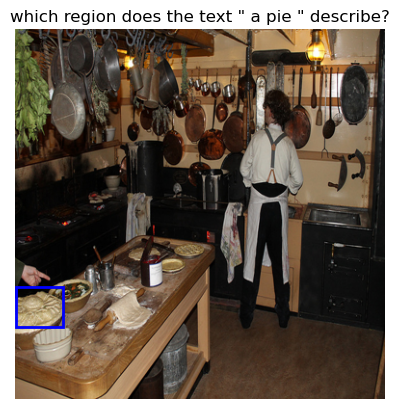

In [137]:
txt = 'which region does the text " a pie " describe?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
bins=tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
plot_image_and_rect(bins, txt)

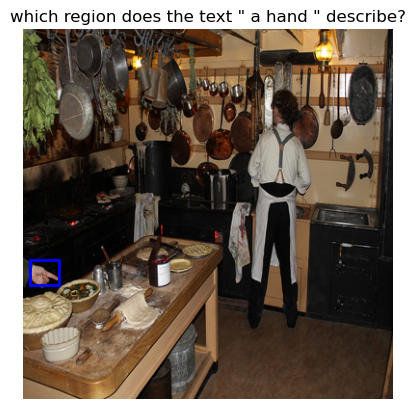

In [130]:
txt = 'which region does the text " a hand " describe?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
bins=tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
plot_image_and_rect(bins, txt)

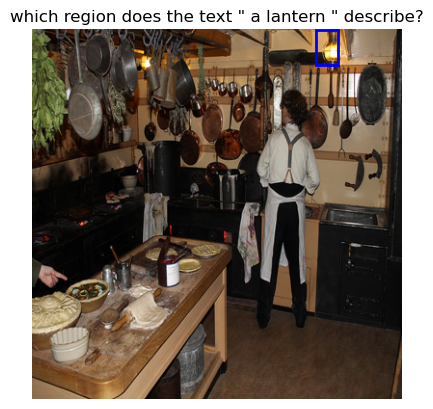

In [131]:
txt = 'which region does the text " a lantern " describe?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
bins=tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
plot_image_and_rect(bins, txt)

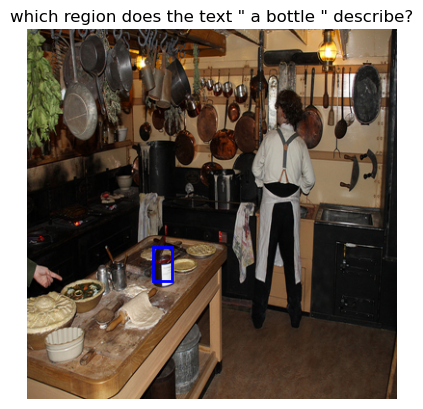

In [132]:
txt = 'which region does the text " a bottle " describe?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
bins=tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
plot_image_and_rect(bins, txt)

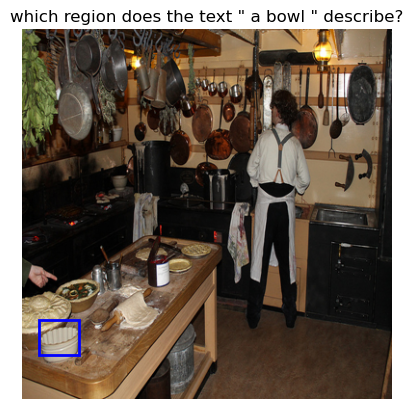

In [133]:
txt = 'which region does the text " a bowl " describe?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
bins=tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
plot_image_and_rect(bins, txt)

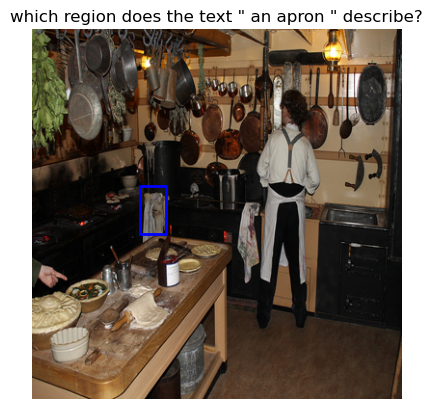

In [135]:
txt = 'which region does the text " an apron " describe?'
inputs = tokenizer([txt], return_tensors="pt").input_ids
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)
bins=tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
plot_image_and_rect(bins, txt)